<a href="https://colab.research.google.com/github/AOdrio/Datathon/blob/main/bolaso%20en%20dos%20partes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
import pandas as pd
import numpy as np

import xgboost as xgb
from matplotlib import pyplot as plt
#import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import accuracy_score as ACC
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.linear_model import LinearRegression as LR
#from sklearn.neighbors import KNeighborsRegressor as KNN

SEED = 42

In [158]:
url='https://drive.google.com/file/d/1KH1fB83JDAWcMRCHKFf9SmcGH7MQkupE/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_original = pd.read_csv(url)

In [ ]:
df_original.describe()

In [160]:
y = df_original.pop("ingreso")
X = df_original.copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [161]:
print('Todo: ',df_original.shape)
print('Train:',X_train.shape)
print('Test: ',X_val.shape)

Todo:  (40000, 24)
Train: (32000, 24)
Test:  (8000, 24)


In [162]:
limite_ingreso = 100000

df_y_train_class = pd.DataFrame(y_train, columns =['ingreso'])
df_y_train_class ['class_ingreso'] = np.where(df_y_train_class.ingreso < limite_ingreso, 1, 0)

In [163]:
y_class = df_y_train_class.pop("class_ingreso")
X_class = X_train.copy()
#X_class = X_class.drop("ingreso",axis=1)

X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.2, random_state=SEED)

In [164]:
def transfromar_DataFrame (df,edad_media, columns):
  df = df.copy()
  df = df.drop(df.columns[0],axis=1)
  #Remplazar nulls de la edad con la media de la columna
  df['edad'] = df['edad'].fillna(edad_media, inplace=False)

  #Transformar categóricas en numéricas
  df['peorcalificacionBCU'] = (df['peorcalificacionBCU'].
                              str.replace('5','6').
                              str.replace('4','5').
                              str.replace('3','4').
                              str.replace('2B','3').
                              str.replace('2A','2').
                              str.replace('1C','1').
                              str.replace('1A','0'))
  df['peorcalificacionBCU'] = pd.to_numeric(df['peorcalificacionBCU'], downcast='integer')
  for column in columns:
    df[column] = np.cbrt(df[column])
    
  return df

In [165]:
edad_media = X_train['edad'].mean()
columns =['vigente', 'vigenteAvg3M', 'vencido','vencidoAvg3M','avgcontingenciaU1M','avgcontingenciaU3M','sumcontingenciaU1M','sumcontingenciaU3M','maxcontingenciaU1M','maxcontingenciaU3M','garantiacomputable'] 

In [166]:
X_class_train = transfromar_DataFrame(X_class_train,edad_media,columns)
X_class_test = transfromar_DataFrame(X_class_test,edad_media,columns)

In [167]:
xgb_classifier = xgb.XGBClassifier(
            objective = "binary:logistic",
            eval_metric = "error",
            #tree_method = "gpu_hist",
            booster = "gbtree",
            random_state = SEED,
            n_estimators = 1000,
            learning_rate = 0.005,
            max_depth = 11,
            min_child_weight = 7,
            subsample = 0.9,
            colsample_bytree = 1,
            colsample_bynode = 0.7,
            colsample_bylevel = 0.8,
            verbosity = 0,
            n_jobs = -1,
            )
xgb_classifier.fit(X_class_train,y_class_train)
preds_class = xgb_classifier.predict(X_class_test)
ACC(y_class_test, preds_class)

0.93609375

In [168]:
mask = y_train<limite_ingreso

X_menor = X_train[mask]
y_menor = y_train[mask]

X_mayor = X_train[~mask]
y_mayor = y_train[~mask]


In [169]:
#y_menor = df_menor.pop("ingreso")
#X_menor = df_menor.copy()
X_train_menor, X_test_menor, y_train_menor, y_test_menor = train_test_split(X_menor, y_menor, test_size=0.2, random_state=SEED)

#edad_media_menor = X_train_menor['edad'].mean()
#columns =['vigente', 'vigenteAvg3M', 'vencido','vencidoAvg3M','avgcontingenciaU1M','avgcontingenciaU3M','sumcontingenciaU1M','sumcontingenciaU3M','maxcontingenciaU1M','maxcontingenciaU3M','garantiacomputable'] 

X_train_menor = transfromar_DataFrame(X_train_menor,edad_media,columns)
X_test_menor = transfromar_DataFrame(X_test_menor,edad_media,columns)
y_train_menor = np.log(y_train_menor)

In [170]:
menor_xgb = xgb.XGBRegressor(
            objective = "reg:squarederror",
            eval_metric = "mae",
            #tree_method = "gpu_hist",
            booster = "gbtree",
            random_state = SEED,
            n_estimators = 1000,
            learning_rate = 0.01,
            max_depth = 11,
            min_child_weight = 7,
            subsample = 0.9,
            colsample_bytree = 1,
            colsample_bynode = 0.7,
            colsample_bylevel = 0.8,
            verbosity = 0,
            n_jobs = -1,
            )

In [171]:
menor_xgb.fit(X_train_menor,y_train_menor)
preds_xgb_menor = menor_xgb.predict(X_test_menor)
preds_xgb_menor = np.exp(preds_xgb_menor)
MAPE_xgb = MAPE(y_test_menor, preds_xgb_menor)
print('MAPE_xgb:', round(100*MAPE_xgb, 2))

MAPE_xgb: 10.6


In [172]:
#y_mayor = df_mayor.pop("ingreso")
#X_mayor = df_mayor.copy()
X_train_mayor, X_test_mayor, y_train_mayor, y_test_mayor = train_test_split(X_mayor, y_mayor, test_size=0.2, random_state=SEED)

#edad_media_mayor = X_train_mayor['edad'].mean()
#columns =['vigente', 'vigenteAvg3M', 'vencido','vencidoAvg3M','avgcontingenciaU1M','avgcontingenciaU3M','sumcontingenciaU1M','sumcontingenciaU3M','maxcontingenciaU1M','maxcontingenciaU3M','garantiacomputable'] 

X_train_mayor = transfromar_DataFrame(X_train_mayor,edad_media,columns)
X_test_mayor = transfromar_DataFrame(X_test_mayor,edad_media,columns)
y_train_mayor = np.log(y_train_mayor)

In [177]:
mayor_xgb = xgb.XGBRegressor(
            objective = "reg:squarederror",
            eval_metric = "mae",
            #tree_method = "gpu_hist",
            booster = "gbtree",
            random_state = SEED,
            n_estimators = 500,
            learning_rate = 0.1,
            max_depth = 9,
            min_child_weight = 7,
            subsample = 0.9,
            colsample_bytree = 1,
            colsample_bynode = 0.7,
            colsample_bylevel = 0.8,
            verbosity = 0,
            n_jobs = -1,
            )
mayor_xgb.fit(X_train_mayor,y_train_mayor)
preds_xgb_mayor = mayor_xgb.predict(X_test_mayor)
preds_xgb_mayor = np.exp(preds_xgb_mayor)
MAPE_xgb_mayor = MAPE(y_test_mayor, preds_xgb_mayor)
print('MAPE_xgb_mayor:', round(100*MAPE_xgb, 2))

MAPE_xgb_mayor: 10.6


In [178]:
X_val = transfromar_DataFrame(X_val,edad_media,columns)

In [180]:
def predecir_ingreso(df):
  df=df.copy()
  pred_class = xgb_classifier.predict(df)
  if pred_class == 1: #menor
    pred_ingreso = menor_xgb.predict(df)
  else: #mayor
    pred_ingreso = mayor_xgb.predict(df)

  pred_ingreso = np.exp(pred_ingreso)  
  return pred_ingreso

In [189]:
pd.DataFrame(predecir_ingreso(X_val.iloc[[0]]))

,0
0,53804.488281


In [193]:
df_preds = pd.DataFrame()
for x in range(X_val.shape[0]):
  a = pd.DataFrame(predecir_ingreso(X_val.iloc[[x]]))
  df_preds = df_preds.append(a, ignore_index=True)
df_preds.head()

,0
0,53804.488281
1,46623.625000
2,42854.523438
3,42116.277344
4,39420.292969


In [195]:
MAPE_xgb = MAPE(y_val, df_preds[0])
print('MAPE_xgb:', round(100*MAPE_xgb, 2))

MAPE_xgb: 12.74


In [ ]:
#data de test
url='https://drive.google.com/file/d/1sMkorQLOmf2cNGRwXkQLKeciGSUpL_ez/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_test_original = pd.read_csv(url)

In [ ]:
df_test = transfromar_DataFrame(df_test_original,edad_media,columns)

In [ ]:
ax = X_train.hist(bins=20, figsize=(15, 10))

In [ ]:
def transfromar_DataFrame (df,edad_media, columns):
  df = df.copy()
  df = df.drop(df.columns[0],axis=1)
  #Remplazar nulls de la edad con la media de la columna
  df['edad'] = df['edad'].fillna(edad_media, inplace=False)

  #Transformar categóricas en numéricas
  df['peorcalificacionBCU'] = (df['peorcalificacionBCU'].
                              str.replace('5','6').
                              str.replace('4','5').
                              str.replace('3','4').
                              str.replace('2B','3').
                              str.replace('2A','2').
                              str.replace('1C','1').
                              str.replace('1A','0'))
  df['peorcalificacionBCU'] = pd.to_numeric(df['peorcalificacionBCU'], downcast='integer')
  for column in columns:
    df[column] = np.cbrt(df[column])
    
  return df

In [ ]:
edad_media = X_train['edad'].mean()
columns =['vigente', 'vigenteAvg3M', 'vencido','vencidoAvg3M','avgcontingenciaU1M','avgcontingenciaU3M','sumcontingenciaU1M','sumcontingenciaU3M','maxcontingenciaU1M','maxcontingenciaU3M','garantiacomputable'] 

In [ ]:
X_train = transfromar_DataFrame(X_train,edad_media,columns)
X_test = transfromar_DataFrame(X_test,edad_media,columns)

In [ ]:
y_train = np.log(y_train)
#y_test = np.cbrt(y_test)

In [ ]:
ax = X_train .hist(bins=20, figsize=(15, 10))

In [ ]:
# La linea base es el mediana de los ingresos
baseline_preds = pd.DataFrame(y_train.copy())
mediana = y_train.median()
baseline_preds['mediana'] = mediana

baseline_MAPE = MAPE(y_train,baseline_preds['mediana'])
print('MAPE linea base: ', round(baseline_MAPE *100, 2))
print('Mediana de ingreso: ', round(mediana))

In [ ]:
model_xgb = xgb.XGBRegressor(
            objective = "reg:squarederror",
            eval_metric = "mae",
            #tree_method = "gpu_hist",
            booster = "gbtree",
            random_state = SEED,
            n_estimators = 1000,
            learning_rate = 0.01,
            max_depth = 11,
            min_child_weight = 7,
            subsample = 0.9,
            colsample_bytree = 1,
            colsample_bynode = 0.7,
            colsample_bylevel = 0.8,
            verbosity = 0,
            n_jobs = -1,
            )

In [ ]:
model_xgb.fit(X_train,y_train)
preds_xgb = model_xgb.predict(X_test)

In [ ]:
preds_xgb = np.exp(preds_xgb)
MAPE_xgb = MAPE(y_test, preds_xgb)
print('MAPE_xgb:', round(100*MAPE_xgb, 2))

MAPE_xgb: 12.07


Text(0.5, 0, 'Xgboost Feature Importance')

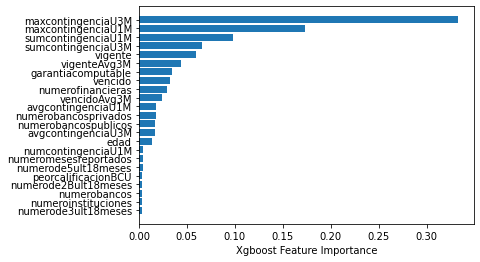

In [ ]:
sorted_idx = model_xgb.feature_importances_.argsort()
plt.barh(list(X_train.columns[sorted_idx]), model_xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [ ]:
#data de test
url='https://drive.google.com/file/d/1sMkorQLOmf2cNGRwXkQLKeciGSUpL_ez/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_test_original = pd.read_csv(url)

In [ ]:
df_test = transfromar_DataFrame(df_test_original,edad_media,columns)


In [ ]:
preds_datathon = model_xgb.predict(df_test)

In [ ]:
pd.DataFrame(preds_datathon).to_csv('predicciones4.csv') 